In [1]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, plot_confusion_matrix, confusion_matrix, mean_absolute_error
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV, cross_val_score
import seaborn as sn 

In [2]:
RSEED = 50
dat21 = pd.read_excel("21_elec/21_election_stats.xlsx", sheet_name="kalpi1")
dat22 = pd.read_excel("21_elec/21_election_stats.xlsx", sheet_name="kalpi2")
dat23 = pd.read_excel("21_elec/21_election_stats.xlsx", sheet_name="kalpi3")
settlements_info = pd.read_excel("cities_and_villages.xlsx")
settlements_info['סך הכל אוכלוסייה 2018'].fillna((settlements_info['סך הכל אוכלוסייה 2018'].median()), inplace=True)
settlements_info.dropna(subset = ['שם יישוב באנגלית'], inplace = True)
settlements_info_with_names = settlements_info.drop(columns =['אשכול רשויות מקומיות','השתייכות ארגונית','ערבים','שיוך מטרופוליני','ועדת תכנון','יהודים ואחרים','תעתיק','מזה: יהודים','שנה','גובה','מרחב משטרה','שנת ייסוד' ,'שם יישוב באנגלית'])
settlements_info = settlements_info.drop(columns =['שם יישוב' , 'אשכול רשויות מקומיות','השתייכות ארגונית','ערבים','שיוך מטרופוליני','ועדת תכנון','יהודים ואחרים','תעתיק','מזה: יהודים','שנה','גובה','מרחב משטרה','שנת ייסוד' ,'שם יישוב באנגלית'])

In [3]:
dict_names = {'מחל': 'likud', 'פה':'kahol-lavan', 'אמת': 'avoda-etc', 'שס': 'shas', 'ג': 'yahadut-hatora', 'ל': 'israel-beitenu', 'טב': 'yamina', 'ודעם': 'meshutefet'}

def merge_parties_and_remove_losers(df):
    df.drop(columns = 'שם ישוב', inplace = True)
    mergable = {'נ': 'טב', 'כ': 'מחל', 'מרצ': 'אמת', 'נר': 'אמת','ום': 'ודעם', 'ז': 'מחל'}
    df.rename(columns = {'דעם': 'ודעם'}, inplace=True)
    
    for key,value in mergable.items():
        if (key in df.columns):
                df[value] += df[key]
                df.drop(columns = key, inplace=True)
                
    thresh = df.sum(axis=0, numeric_only = True) 
    df = df[df.columns[thresh>100000]]
    df.rename(columns = dict_names, inplace = True)
    return df

In [4]:
settlements_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1261 entries, 0 to 1481
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   סמל יישוב              1261 non-null   int64  
 1   מחוז                   1261 non-null   int64  
 2   נפה                    1261 non-null   int64  
 3   אזור טבעי              1134 non-null   float64
 4   מעמד מונציפאלי         1230 non-null   float64
 5   דת יישוב               1246 non-null   float64
 6   סך הכל אוכלוסייה 2018  1261 non-null   float64
 7   צורת יישוב שוטפת       1261 non-null   int64  
 8   קואורדינטות            1261 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 98.5 KB


# As shown, we have a lot of data with high correlation, in order to avoid overfitting and eventualy having a good model - we will get rid of unnecessary and highly correlated data

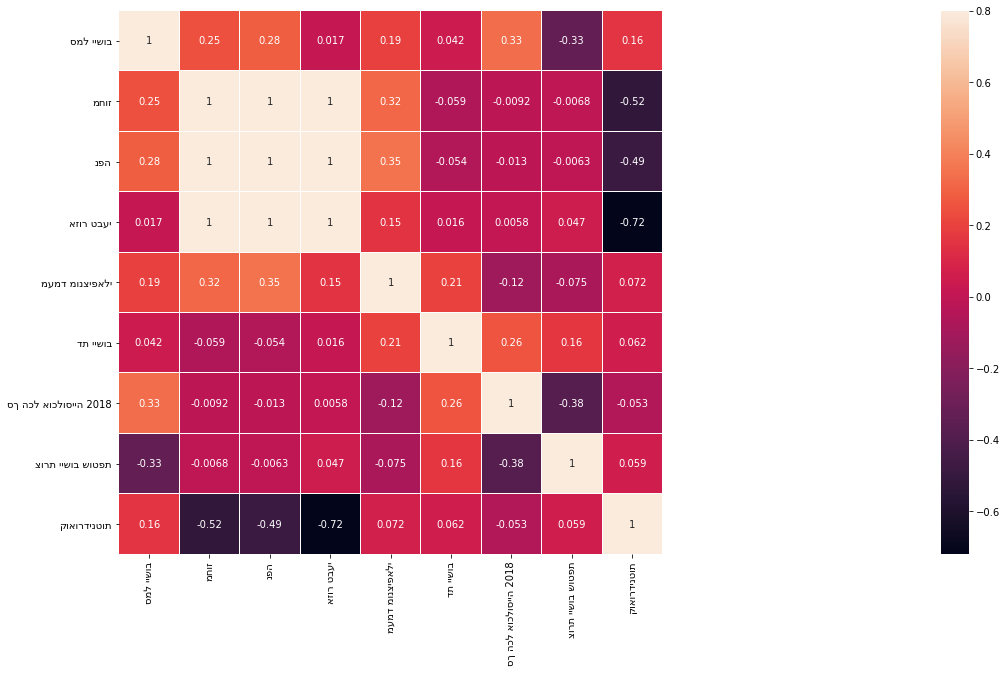

In [5]:
corrMatrix = settlements_info.corr()
plt.figure(figsize=(100, 10))
sn.heatmap(corrMatrix, vmax=.8, linewidths=0.01, square=True,annot=True)
plt.show()

# 1+2- arrange and adjust the data

In [6]:
dat23 = dat23.drop(columns =['ריכוז', 'שופט'])
dat22 = dat22.drop(columns =['ריכוז', 'שופט'])
#We decided to delete these columns because they do not appear in the data of election 21 and we found them irrelevant

#we We will mrege the parties that united in elections 23 and 22, in dat21 and dat22
dat21['ודעם'] = dat21['ום'] + dat21['דעם']
dat21['טב'] = dat21['טב'] + dat21['נ']
dat21['מחל'] = dat21['מחל'] + dat21['כ']
dat21['אמת'] = dat21['אמת'] + dat21['נר'] + dat21['מרצ']
dat22['אמת'] = dat22['אמת'] + dat22['מרצ']


dat21 = dat21.drop(columns =['מרצ','כ','דעם', 'ום', 'נ', 'נר'])
dat22 = dat22.drop(columns ='מרצ')

## Results of the three elections after adjusting the data of the 8 biggest parties

In [7]:
votes_of_21 = dat21.כשרים.sum()
parties_votes_21 = dat21.iloc[:,7:].sum()

votes_of_22 = dat22.כשרים.sum()
parties_votes_22 = dat22.iloc[:,9:].sum()

votes_of_23 = dat23.כשרים.sum()
parties_votes_23 = dat23.iloc[:,9:].sum()


best_8_23= parties_votes_23.sort_values(ascending=False).head(8).sort_index()
best_8_23= best_8_23/votes_of_23
best_8_22= parties_votes_22.sort_values(ascending=False).head(8).sort_index()
best_8_22= best_8_22/votes_of_22
best_8_21= parties_votes_21.sort_values(ascending=False).head(8).sort_index()
best_8_21= best_8_21/votes_of_21

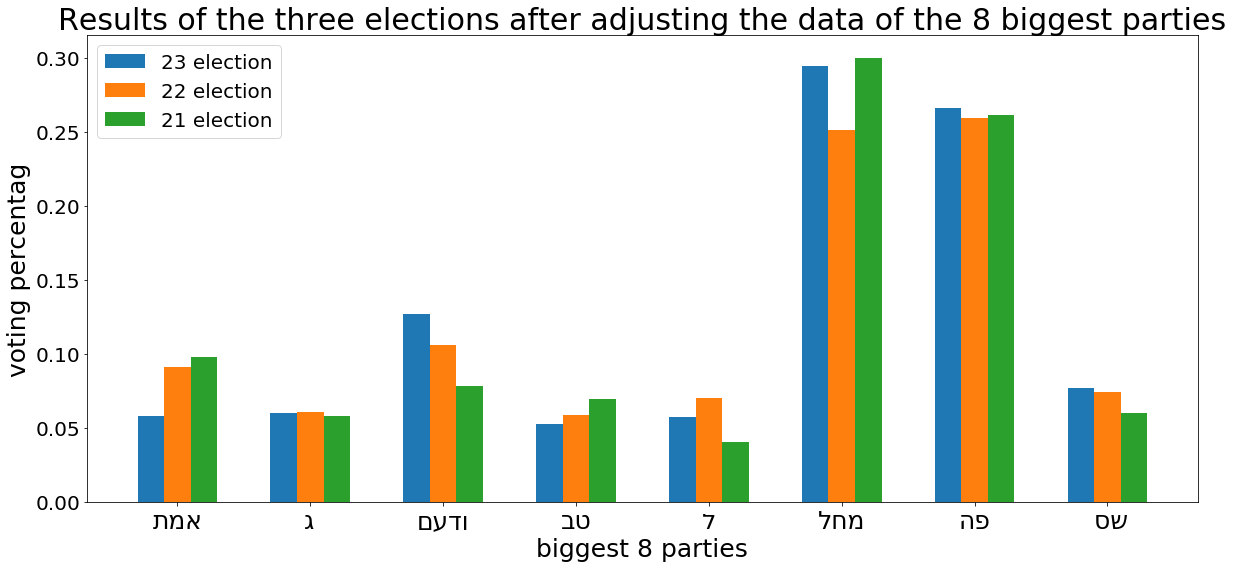

In [8]:
parties_names= ['תמא', 'ג' , 'םעדו', 'בט', 'ל', 'לחמ' , 'הפ', ' סש']
x = np.arange(len(best_8_23.index))
fig, ax = plt.subplots(figsize=(18,8))
rects1 = ax.bar(x-0.2 , best_8_23.values, width=0.2, label='23 election')
rects2 = ax.bar(x , best_8_22.values, width=0.2, label='22 election')
rects3 = ax.bar(x + 0.2, best_8_21.values, width=0.2, label='21 election')
ax.legend(fontsize = 20)

ax.set_ylabel('voting percentag',fontsize = 25)
ax.set_xlabel('biggest 8 parties',fontsize = 25)
ax.set_title('Results of the three elections after adjusting the data of the 8 biggest parties',fontsize = 30)
ax.set_xticks(x)
ax.tick_params(labelsize=20)
ax.set_xticklabels(parties_names,fontsize = 25)


fig.tight_layout()

plt.show()

In [9]:
best_8_23.to_frame('elec23').join(best_8_22.rename('elec22'), how='inner').join(best_8_21.rename('elec21'), how='inner').round(2)

,elec23,elec22,elec21
אמת,0.06,0.09,0.10
ג,0.06,0.06,0.06
ודעם,0.13,0.11,0.08
טב,0.05,0.06,0.07
ל,0.06,0.07,0.04
מחל,0.29,0.25,0.30
פה,0.27,0.26,0.26
שס,0.08,0.07,0.06


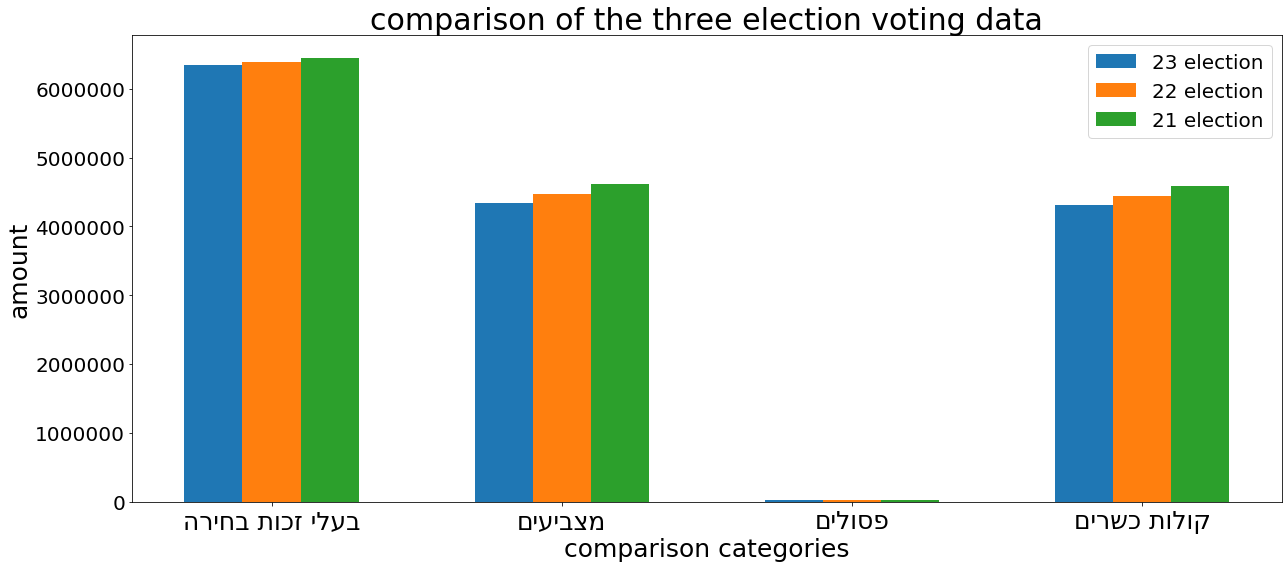

In [10]:
voting_21_data=dat21.iloc[:,3:7].sum()
voting_22_data=dat22.iloc[:,5:9].sum()
voting_23_data=dat23.iloc[:,5:9].sum()

comparison_categories= ['הריחב תוכז ילעב', 'םיעיבצמ' , 'םילוספ', 'םירשכ תולוק']

x = np.arange(len(voting_21_data.index))
fig, ax = plt.subplots(figsize=(18,8))
rects1 = ax.bar(x-0.2 , voting_21_data.values, width=0.2, label='23 election')
rects2 = ax.bar(x , voting_22_data.values, width=0.2, label='22 election')
rects3 = ax.bar(x + 0.2, voting_23_data.values, width=0.2, label='21 election')
ax.legend(fontsize = 20)

ax.set_ylabel('amount',fontsize = 25)
ax.set_xlabel('comparison categories',fontsize = 25)
ax.set_title('comparison of the three election voting data',fontsize = 30)
ax.set_xticks(x)
ax.tick_params(labelsize=20)
ax.set_xticklabels(comparison_categories,fontsize = 25)

fig.tight_layout()

plt.show()


# 3- clustering

## k-means

In [11]:
dat21_clustering=dat21.iloc[:,1:].drop(columns =['מצביעים','כשרים','פסולים' ,'מספר קלפי', 'בזב']).groupby(['סמל ישוב']).sum()

dat22_clustering=dat22.iloc[:,3:].drop(columns =['מצביעים', 'כשרים','פסולים' ,'קלפי', 'בזב']).groupby(['סמל ישוב']).sum()

dat23_clustering=dat23.iloc[:,2:].drop(columns =['כשרים','פסולים' ,'קלפי', 'בזב']).groupby(['שם ישוב']).sum()

dat23_clustering.head()

,סמל ישוב,מצביעים,אמת,ג,ודעם,ז,זך,זץ,טב,י,...,נץ,נק,פה,ףז,ץ,ק,קי,קך,קץ,שס
שם ישוב,,,,,,,,,,,,,,,,,,,,,
אבו גווייעד שבט,2901,595,13,0,554,0,0,0,0,0,...,0,0,8,2,0,0,0,0,2,2
אבו גוש,3776,2718,75,4,2157,0,0,0,5,0,...,3,2,123,0,2,0,0,1,4,14
אבו סנאן,6149,6090,92,6,4458,0,1,0,16,1,...,3,3,752,0,2,2,1,2,4,247
אבו עבדון שבט,958,41,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
אבו קורינאת שבט,3872,1336,9,0,1263,0,0,0,1,0,...,1,0,33,0,2,1,0,2,1,0


In [12]:
dat23_clustering = dat23_clustering.rename(columns = {"מצביעים": "voters"})

pres_dat23_clustering= dat23_clustering.iloc[:,1:].div(dat23_clustering.voters, axis=0)
pres_dat23_clustering = pres_dat23_clustering.drop(columns =['voters'])
pres_dat23_clustering

,אמת,ג,ודעם,ז,זך,זץ,טב,י,יז,ינ,...,נץ,נק,פה,ףז,ץ,ק,קי,קך,קץ,שס
שם ישוב,,,,,,,,,,,,,,,,,,,,,
אבו גווייעד שבט,0.021849,0.000000,0.931092,0.000000,0.000000,0.0,0.000000,0.000000,0.001681,0.000000,...,0.000000,0.000000,0.013445,0.003361,0.000000,0.000000,0.000000,0.000000,0.003361,0.003361
אבו גוש,0.027594,0.001472,0.793598,0.000000,0.000000,0.0,0.001840,0.000000,0.000000,0.001840,...,0.001104,0.000736,0.045254,0.000000,0.000736,0.000000,0.000000,0.000368,0.001472,0.005151
אבו סנאן,0.015107,0.000985,0.732020,0.000000,0.000164,0.0,0.002627,0.000164,0.000328,0.002135,...,0.000493,0.000493,0.123481,0.000000,0.000328,0.000328,0.000164,0.000328,0.000657,0.040558
אבו עבדון שבט,0.000000,0.000000,0.975610,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
אבו קורינאת שבט,0.006737,0.000000,0.945359,0.000000,0.000000,0.0,0.000749,0.000000,0.000000,0.002246,...,0.000749,0.000000,0.024701,0.000000,0.001497,0.000749,0.000000,0.001497,0.000749,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
תקומה,0.012019,0.012019,0.000000,0.000000,0.000000,0.0,0.391827,0.000000,0.000000,0.000000,...,0.004808,0.002404,0.151442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028846
תקוע,0.017295,0.020383,0.001853,0.004324,0.000000,0.0,0.469426,0.000000,0.000000,0.000000,...,0.017912,0.000000,0.052502,0.001235,0.000000,0.000618,0.000000,0.001235,0.003088,0.021001
תראבין אצאנע שבט,0.000000,0.000000,0.895833,0.000000,0.020833,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


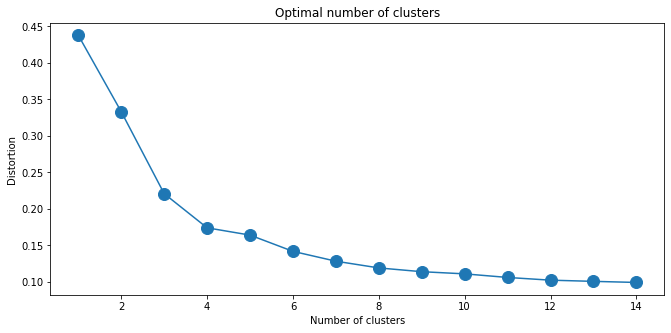

In [13]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, max_iter=10000).fit(pres_dat23_clustering)
    kmeanModel.fit(pres_dat23_clustering)
    distortions.append(sum(np.min(cdist(pres_dat23_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pres_dat23_clustering.shape[0])
plt.figure(figsize=(11, 5))
plt.plot(K, distortions, 'o-', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Optimal number of clusters')
plt.show()

In [14]:
sett_names_23= dat23.iloc[:,1:].groupby(['שם ישוב']).sum().sort_values(by=['כשרים'],ascending=False)
sett_names_23 = sett_names_23.index
sett_names_23

Index(['מעטפות חיצוניות', 'תל אביב  יפו', 'ירושלים', 'חיפה', 'ראשון לציון',
       'פתח תקווה', 'אשדוד', 'נתניה', 'חולון', 'באר שבע',
       ...
       'תראבין אצאנע שבט', 'אבו עבדון שבט', 'איבים', 'כפר סילבר', 'בית צבי',
       'עטאוונה שבט', 'אלוני יצחק', 'נווה זוהר', 'עין קנייא', 'שער מנשה'],
      dtype='object', name='שם ישוב', length=1214)

In [15]:
kmeanModel = KMeans(n_clusters=6, max_iter=10000, random_state=0).fit(pres_dat23_clustering)
df_clusts = pd.DataFrame({'ID': pres_dat23_clustering.index, 'clusts': kmeanModel.labels_})
pres_dat23_clustering = pd.merge(pres_dat23_clustering, df_clusts, right_on='ID', left_index=True)

# Add top parties in each cluster
data = pres_dat23_clustering.drop('ID', axis=1)
data = data.groupby('clusts').sum()
for i in data.index:
    data.iloc[i,:] = round(data.iloc[i,:]/data.iloc[i,:].sum()*100, 2).tolist()
data1 = pd.DataFrame({'clusts': data.index,
                     'party': str(data.index)})
for i in data.index:
    reg = re.sub(' {2,}', ' - ', str(data.iloc[i,:].sort_values(ascending=False)[0:4]))
    reg = re.sub('\n', ' , ', reg)
    reg = re.sub(', Name:.*', '', reg)
    data1.iloc[i,1] = reg
data = data1
del data1


data.clusts

# Add cities in each clust
data['cities'] = 'text'
settles = pres_dat23_clustering[['ID', 'clusts']]
clusters = settles
#settles.index = settles.pop('ID')
settles.set_index('ID', inplace = True)

settles = settles.filter(items=sett_names_23, axis=0).reset_index()

for i in set(data.clusts):
    reg = ', '.join(settles.ID[settles.clusts == i])
    data.loc[i,'cities'] = reg

# Add number of all cities in each cluster
data = pd.merge(data, pres_dat23_clustering.groupby('clusts')['ID'].count().reset_index())
data = data.drop('clusts', axis=1)
data.columns = ['Top 4 parties by % of votes in the cluster', 
                'The biggest cities in the cluster',
                'settelments amount in the clust']

In [16]:
data # clustering results 

,Top 4 parties by % of votes in the cluster,The biggest cities in the cluster,settelments amount in the clust
0,"פה - 60.27 , אמת - 22.08 , מחל - 10.55 , ל - 2...","גבעתיים, רמת השרון, קרית טבעון, בנימינהגבעת עד...",455
1,"ג - 53.49 , שס - 22.42 , מחל - 11.79 , טב - 8.13","ירושלים, בני ברק, בית שמש, מודיעין עילית, ביתר...",25
2,"ודעם - 91.05 , פה - 3.32 , אמת - 2.50 , מחל - ...","נצרת, אום אלפחם, רהט, טייבה, שפרעם, טמרה, סחני...",128
3,"טב - 56.18 , מחל - 26.49 , פה - 5.55 , ג - 3.87","אפרת, קרני שומרון, קרית ארבע, בית אל, אלקנה, ק...",134
4,"פה - 43.72 , מחל - 32.11 , אמת - 9.04 , טב - 5...","מעטפות חיצוניות, תל אביב יפו, חיפה, ראשון לצי...",226
5,"מחל - 56.57 , פה - 14.42 , שס - 11.79 , טב - 6...","אשדוד, נתניה, באר שבע, אשקלון, בת ים, חדרה, רמ...",246


In [17]:
israel = pd.read_excel("cities_and_villages.xlsx")
israel['קואורדינטות'].fillna((settlements_info['קואורדינטות'].mean()), inplace=True)
to_plt = israel.set_index('שם יישוב').join(clusters, how = 'inner')

In [18]:
to_plt.sort_values(by = ['סך הכל אוכלוסייה 2018'], ascending = False, inplace= True)

In [19]:
df_plt = to_plt[['clusts', 'קואורדינטות']].copy()
df_plt['x_cor'], df_plt['y_cor'] = (to_plt['קואורדינטות']/100000).astype(int), (to_plt['קואורדינטות']%100000).astype(int)

In [20]:
def reverseFloats(s):
    words = s[::-1].split(" ")
    for i in range(len(words) -1):
        word = words[i]
        if any(i.isdigit() for i in word):
            words[i] = word[::-1]
    s = ' '.join([str(elem) for elem in words]) 
    return s

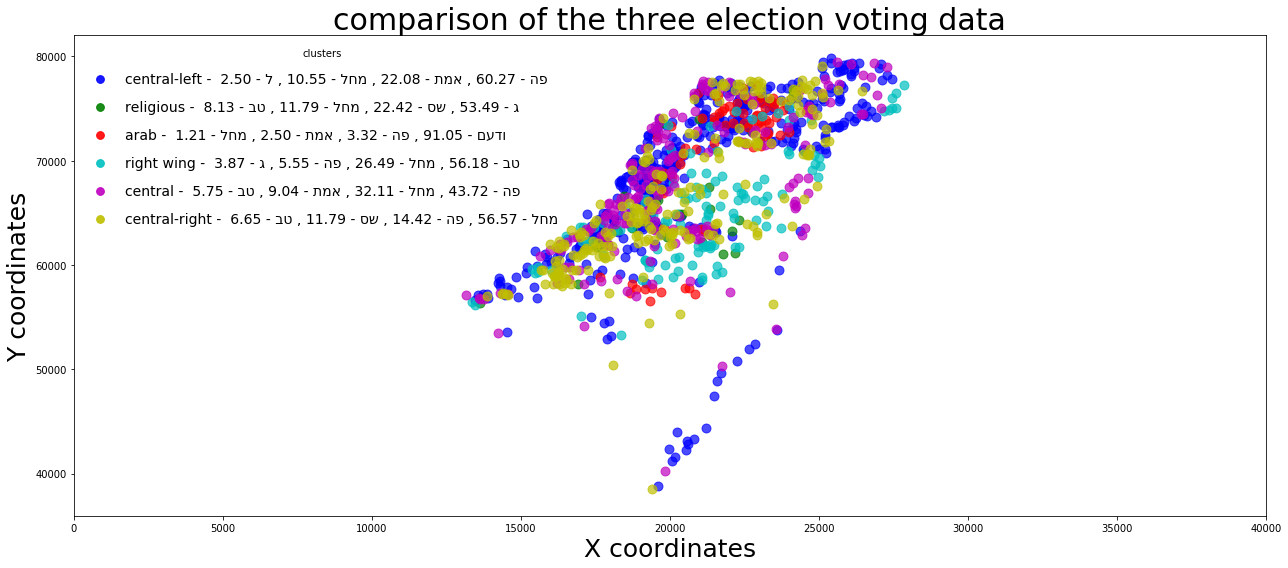

In [21]:
population = to_plt['סך הכל אוכלוסייה 2018']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
fig, ax = plt.subplots(figsize=(18,8))
for i in range(0,6):
    filt = df_plt['clusts'] == i
    plt.scatter(df_plt.loc[filt,'x_cor'], df_plt.loc[filt,'y_cor'],c= colors[i], s= 80, alpha=0.7)
plt.xlim(0,40000)
ax.set_ylabel('Y coordinates',fontsize = 25)
ax.set_xlabel('X coordinates',fontsize = 25)
ax.set_title('comparison of the three election voting data',fontsize = 30)

labels = ['central-left', 'religious', 'arab', 'right wing', 'central', 'central-right']
for i in range(0,6):
    plt.scatter([], [], alpha=0.9, s=60, c= colors[i],
                label= labels[i]+ " - " +reverseFloats("".join(str(data.iloc[i,0]))))
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='clusters', fontsize = 14)


fig.tight_layout()

plt.show()

In [22]:
clusters

,clusts
ID,
אבו גווייעד שבט,2
אבו גוש,2
אבו סנאן,2
אבו עבדון שבט,2
אבו קורינאת שבט,2
...,...
תקומה,3
תקוע,3
תראבין אצאנע שבט,2


In [23]:
to_join = pd.read_excel("cities_and_villages.xlsx")
vbc23 = pd.read_excel("21_elec/21_election_stats.xlsx" , sheet_name ="cities3")


In [24]:
vbc23 = merge_parties_and_remove_losers(vbc23)
vbc23 = vbc23.set_index('סמל ישוב')
vbc23 = vbc23.div(vbc23['מצביעים'], axis=0)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
clust_df = clusters.join(to_join.set_index('שם יישוב'), how = 'inner')
clust_df = clust_df.drop(columns = ['אשכול רשויות מקומיות','השתייכות ארגונית','ערבים','שיוך מטרופוליני','ועדת תכנון','יהודים ואחרים','תעתיק','מזה: יהודים','שנה','גובה','מרחב משטרה','שנת ייסוד' ,'שם יישוב באנגלית'])
clust_df = clust_df.drop(columns = ['מחוז', 'נפה','צורת יישוב שוטפת' ,'אזור טבעי' ,'מעמד מונציפאלי'])

In [26]:
df_gmm = clust_df.set_index('סמל יישוב', drop = True).join(vbc23, how= 'inner')

In [27]:
toplt = df_gmm.drop(columns = ['בזב','סך הכל אוכלוסייה 2018'])

In [28]:
df_gmm['x_cor'], df_gmm['y_cor'] = (df_gmm['קואורדינטות']/100000).astype(int), (df_gmm['קואורדינטות']%100000).astype(int)
df_gmm

,clusts,דת יישוב,סך הכל אוכלוסייה 2018,קואורדינטות,בזב,מצביעים,כשרים,avoda-etc,yahadut-hatora,meshutefet,yamina,israel-beitenu,likud,kahol-lavan,shas,x_cor,y_cor
472,2,2.0,7543.0,2.105263e+09,1.773731,1.0,0.986755,0.027594,0.001472,0.793598,0.001840,0.001840,0.103017,0.045254,0.005151,21052,63481
473,2,2.0,13915.0,2.160776e+09,1.547126,1.0,0.991297,0.015107,0.000985,0.732020,0.003120,0.037767,0.031363,0.123481,0.040558,21607,76284
1375,2,2.0,1822.0,1.933457e+09,1.637153,1.0,0.996528,0.000000,0.000000,0.980903,0.001736,0.000000,0.000000,0.005208,0.003472,19334,56589
652,2,2.0,2773.0,2.108874e+09,1.565891,1.0,0.991387,0.003445,0.000000,0.956072,0.000861,0.000861,0.007752,0.015504,0.000861,21088,74076
1275,0,1.0,470.0,2.331475e+09,1.321888,1.0,1.000000,0.150215,0.000000,0.030043,0.081545,0.017167,0.111588,0.609442,0.000000,23314,74908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,5,1.0,616.0,1.976963e+09,1.225071,1.0,0.994302,0.091168,0.005698,0.002849,0.094017,0.022792,0.458689,0.210826,0.102564,19769,63427
709,1,1.0,2163.0,1.693658e+09,1.160735,1.0,0.994259,0.001148,0.758898,0.000000,0.008037,0.000000,0.070034,0.010333,0.145809,16936,58163
665,3,1.0,699.0,1.600360e+09,1.173077,1.0,0.995192,0.012019,0.012019,0.000000,0.394231,0.002404,0.387019,0.151442,0.028846,16003,59560
3563,3,1.0,3882.0,2.218962e+09,1.332922,1.0,0.997529,0.017295,0.020383,0.001853,0.470661,0.021618,0.367511,0.052502,0.021001,22189,61753


In [29]:
df_gmm = df_gmm.drop(columns = ['קואורדינטות', 'סך הכל אוכלוסייה 2018'])

# We can clearly see a high resemblence between our KMeans that considered all parties and GMM that considered only the top 8 parties of the 23rd elections
## Of that we can conclude that both algorithms succefully clustered 6 different groups of approximately the same voting habits

Text(0.5, 1.0, '23rd elections clustering')

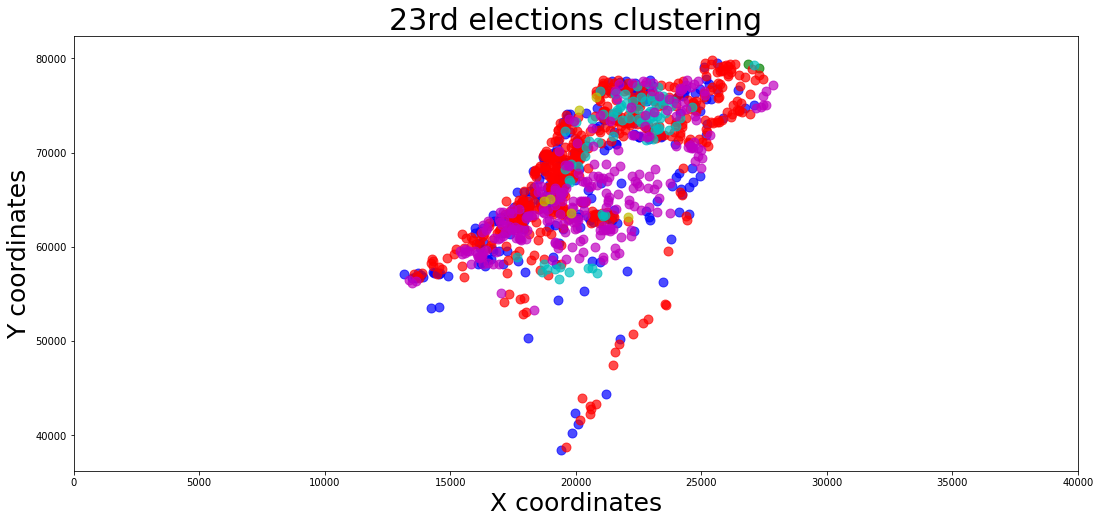

In [91]:
from sklearn.mixture import GaussianMixture

colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, ax = plt.subplots(figsize=(18,8))
gmm = GaussianMixture(n_components=6).fit(df_gmm.iloc[:,1:13])
labels = gmm.predict(df_gmm.iloc[:,1:13])
df_gmm['lables'] = labels
for i in range(0,6):
    filt = df_gmm['lables'] == i
    plt.scatter(df_gmm.loc[filt,'x_cor'], df_gmm.loc[filt,'y_cor'],c= colors[i], s= 80, alpha=0.7)

plt.xlim(0,40000)
ax.set_ylabel('Y coordinates',fontsize = 25)
ax.set_xlabel('X coordinates',fontsize = 25)
ax.set_title('23rd elections clustering',fontsize = 30)


# scatter matrix denotes of normalized votes and their clusters 
### (created with the KMeans above)

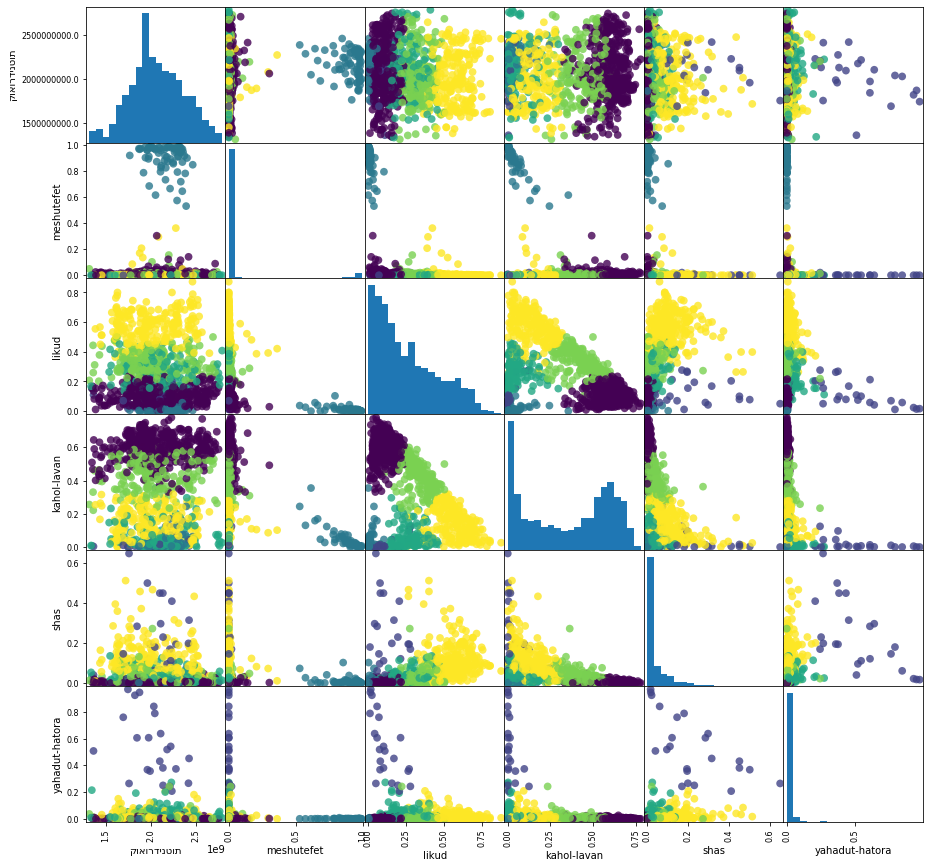

In [31]:
dataframe = pd.DataFrame(toplt[['קואורדינטות', 'meshutefet', 'likud', 'kahol-lavan', 'shas', 'yahadut-hatora']], columns=['קואורדינטות', 'meshutefet', 'likud', 'kahol-lavan', 'shas', 'yahadut-hatora'])
pd.plotting.scatter_matrix(dataframe,c=toplt['clusts'] ,figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8)
plt.show()

## In our opinion KMeans is more suited for finding clusters for this particular problem because the data is numeric and KMeans' euclidean distance is a very helpfull tool in this situation rather than having Gaussian Mixture

# 4- random forest

In [32]:
#arrange the data
temp_21 = dat21.groupby(['סמל ישוב', 'שם ישוב']).sum()
temp_21 =temp_21.reset_index()
temp_21 = temp_21.set_index('סמל ישוב')
temp_21 = temp_21.loc[:, ['בזב', 'כשרים']]
merged_df_21 = temp_21.join(settlements_info.set_index('סמל יישוב'), how='inner', sort=False)
merged_df_21

,בזב,כשרים,מחוז,נפה,אזור טבעי,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,צורת יישוב שוטפת,קואורדינטות
7,516,371,6,61,612.0,50.0,1.0,875.0,310,1.739861e+09
10,333,235,1,11,112.0,26.0,1.0,501.0,310,1.892863e+09
11,403,288,6,61,612.0,50.0,1.0,552.0,310,1.729761e+09
13,502,403,6,62,625.0,54.0,1.0,605.0,310,2.266752e+09
15,302,215,6,61,612.0,34.0,1.0,349.0,310,1.799961e+09
...,...,...,...,...,...,...,...,...,...,...
9400,23080,17137,4,42,422.0,0.0,1.0,29930.0,160,1.893966e+09
9500,34220,22011,3,31,311.0,0.0,1.0,39927.0,160,2.087275e+09
9600,36506,20887,3,31,311.0,0.0,1.0,39909.0,160,2.070575e+09
9700,45512,34800,4,42,421.0,0.0,1.0,62325.0,150,1.901767e+09


In [33]:
temp_22 = dat22.groupby(['סמל ישוב', 'שם ישוב']).sum()
temp_22 = temp_22.reset_index()
temp_22 = temp_22.set_index('סמל ישוב')
temp_22 = temp_22.loc[:, ['בזב', 'כשרים']]
merged_df_22 = temp_22.join(settlements_info.set_index('סמל יישוב'), how='inner', sort=False)
merged_df_22

,בזב,כשרים,מחוז,נפה,אזור טבעי,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,צורת יישוב שוטפת,קואורדינטות
7,517,377,6,61,612.0,50.0,1.0,875.0,310,1.739861e+09
10,332,245,1,11,112.0,26.0,1.0,501.0,310,1.892863e+09
11,406,287,6,61,612.0,50.0,1.0,552.0,310,1.729761e+09
13,502,373,6,62,625.0,54.0,1.0,605.0,310,2.266752e+09
15,308,227,6,61,612.0,34.0,1.0,349.0,310,1.799961e+09
...,...,...,...,...,...,...,...,...,...,...
9400,23181,17101,4,42,422.0,0.0,1.0,29930.0,160,1.893966e+09
9500,34213,21596,3,31,311.0,0.0,1.0,39927.0,160,2.087275e+09
9600,36529,20494,3,31,311.0,0.0,1.0,39909.0,160,2.070575e+09
9700,45835,34505,4,42,421.0,0.0,1.0,62325.0,150,1.901767e+09


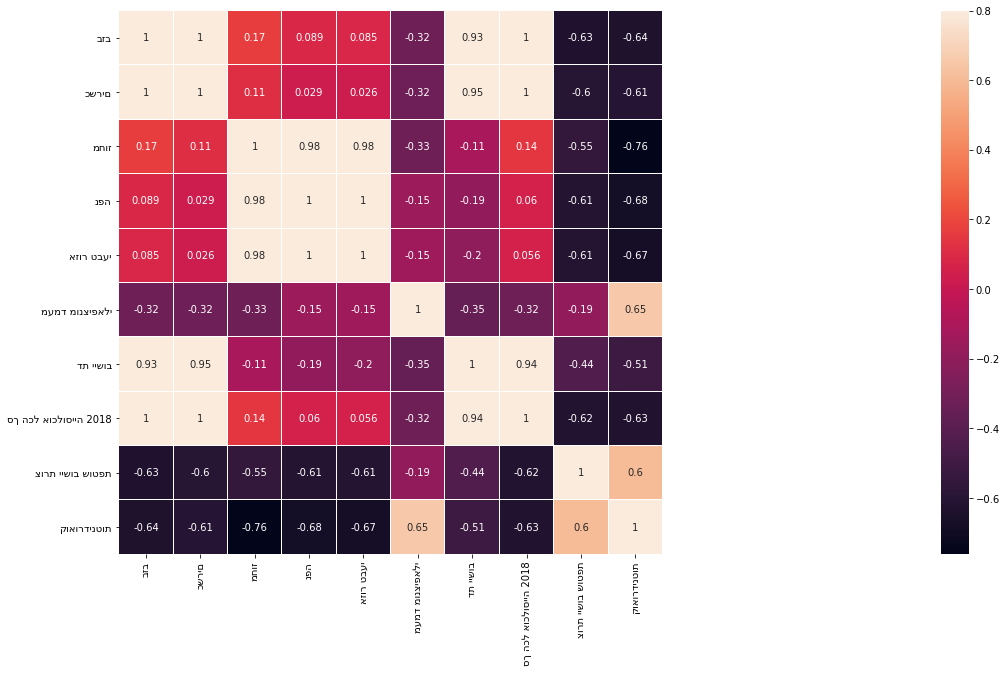

,בזב,כשרים,מחוז,נפה,אזור טבעי,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,צורת יישוב שוטפת,קואורדינטות
סמל ישוב,,,,,,,,,,
4000.0,249627,144625,3.0,31.0,311.0,0.0,4.0,283640.0,130.0,2.011275e+09
77.0,818,585,2.0,21.0,211.0,1.0,1.0,1134.0,330.0,2.541977e+09
4100.0,6175,3498,2.0,29.0,293.0,99.0,1.0,7132.0,180.0,2.646577e+09
2600.0,50714,22636,6.0,62.0,625.0,0.0,1.0,51935.0,150.0,1.941739e+09
7500.0,21624,17085,2.0,24.0,241.0,0.0,2.0,31057.0,260.0,2.283275e+09


In [34]:
temp_23 = dat23.groupby(['סמל ישוב']).sum()
temp_23 = temp_23.reset_index()
temp_23 = temp_23.set_index('סמל ישוב')
temp_23 = temp_23.loc[:, ['בזב', 'כשרים']]
merged = temp_23.join(settlements_info.set_index('סמל יישוב'), how = 'left')
merged_df_23 = merged
merged_df_23 = merged_df_23.loc[[4000.0, 77.0, 4100.0, 2600.0, 7500.0]]


corrMatrix = merged_df_23.corr()
plt.figure(figsize=(100, 10))
sn.heatmap(corrMatrix, vmax=.8, linewidths=0.01, square=True,annot=True)
plt.show()
merged_df_23

In [35]:

X_train = merged_df_21.drop(columns = ['אזור טבעי','צורת יישוב שוטפת','מחוז','סך הכל אוכלוסייה 2018'])
X_test = merged_df_22.drop(columns = ['אזור טבעי','צורת יישוב שוטפת','מחוז','סך הכל אוכלוסייה 2018'])
X_last_vote = merged_df_23.drop(columns = ['אזור טבעי','צורת יישוב שוטפת','מחוז','סך הכל אוכלוסייה 2018'])

print(X_train.count())

X_test = X_test.dropna(how = 'any', axis = 0)
X_train = X_train.dropna(how = 'any', axis = 0)
X_last_vote = X_last_vote.dropna(how = 'any', axis = 0)

y_train = X_train['כשרים']
y_test = X_test['כשרים']
y_last_vote = X_last_vote['כשרים']

#we dropped the "population size" after the first run of the decision tree beacuse we saw that most of the tree based on it,
#and we know that big part of the data based on avarages data

בזב               1212
כשרים             1212
נפה               1212
מעמד מונציפאלי    1190
דת יישוב          1205
קואורדינטות       1212
dtype: int64


In [36]:
X_test = X_test.drop(columns = 'כשרים')
X_train = X_train.drop(columns = 'כשרים')
X_last_vote = X_last_vote.drop(columns = 'כשרים')

In [37]:
#df.set_index('סמל יישוב', drop = False).join(vbc23.set_index('סמל ישוב'), how= 'inner')

In [38]:
X_train.corr()

,בזב,נפה,מעמד מונציפאלי,דת יישוב,קואורדינטות
בזב,1.000000,0.001879,-0.143241,0.330557,-0.073768
נפה,0.001879,1.000000,0.347375,-0.166620,-0.490250
מעמד מונציפאלי,-0.143241,0.347375,1.000000,0.206944,0.071589
דת יישוב,0.330557,-0.166620,0.206944,1.000000,0.110565
קואורדינטות,-0.073768,-0.490250,0.071589,0.110565,1.000000


In [39]:
reg_tree = DecisionTreeRegressor(criterion = 'mae')
reg_tree = reg_tree.fit(X_train,y_train)
y_pred = reg_tree.predict(X_test)
# Model Accuracy
print("mae:", mean_absolute_error(y_test, y_pred))
features = list(X_train.columns)
fi = pd.DataFrame({'feature': features,
                   'importance': reg_tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

mae: 139.31530008453086


,feature,importance
0,בזב,0.931110
4,קואורדינטות,0.037116
1,נפה,0.015804
3,דת יישוב,0.012585
2,מעמד מונציפאלי,0.003385


# random forrest hyper parameter tuning

In [40]:
# Hyperparameter grid
param_grid_rf_reg = {
    'criterion':['mae'],
    'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
    'max_depth': [None, 10, 20 , 30], #50, 60, 70] ,#The maximum depth of the tree.
    'max_features': ['sqrt'],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True,False]#Whether bootstrap samples are used when building trees.
}

# Estimator for use in random search
estimator_reg = RandomForestRegressor()

# Create the random search model
rs_reg = GridSearchCV(estimator_reg, param_grid_rf_reg, n_jobs = -1, 
                        scoring = 'neg_mean_squared_error', cv = 7,
                        verbose = 1)

# Fit 
rs_reg.fit(X_train, y_train)

Fitting 7 folds for each of 96 candidates, totalling 672 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 672 out of 672 | elapsed: 16.0min finished


GridSearchCV(cv=7, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [41]:
best_model = rs_reg.best_estimator_
best_model

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [42]:
features = list(X_train.columns)
fi = pd.DataFrame({'feature': features,
                   'importance': best_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
0,בזב,0.613882
2,מעמד מונציפאלי,0.208181
4,קואורדינטות,0.081529
1,נפה,0.057509
3,דת יישוב,0.038899


In [43]:
last = best_model.predict(X_last_vote)
last

array([144578.        ,    549.88333333,   3847.36666667,  23309.38333333,
        15842.10666667])

In [44]:
predictions = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, predictions))

MAE: 142.55385460693154


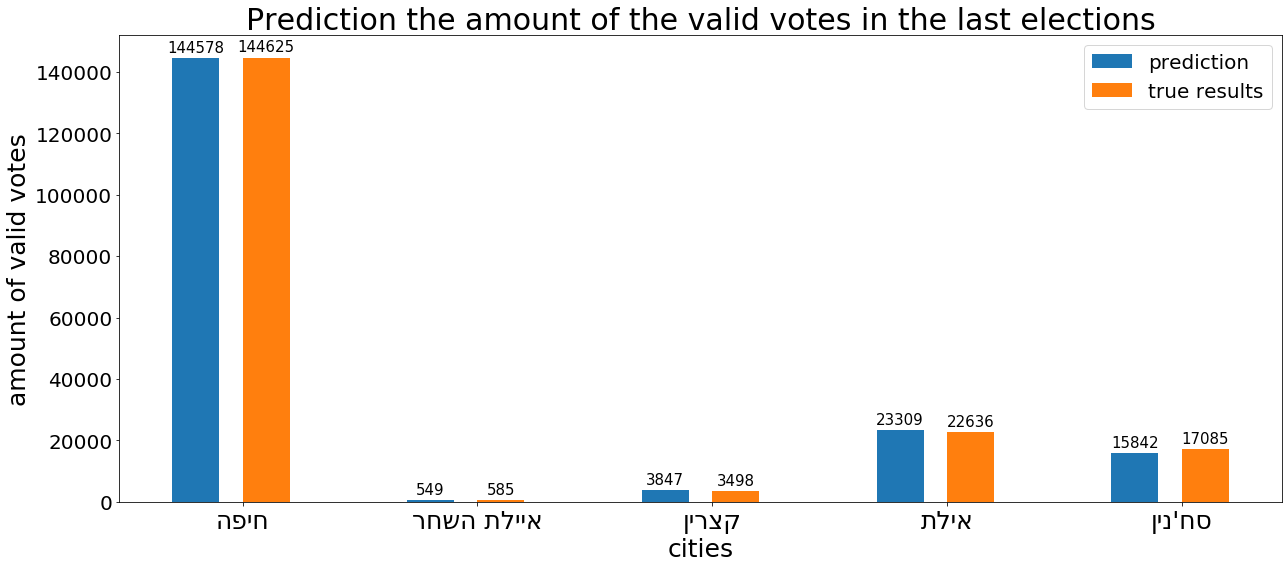

In [45]:
cities_names = ["הפיח","רחשה תלייא", "ןירצק", "תליא",  "ןינ'חס"]
x = np.arange(len(y_last_vote.index))
fig, ax = plt.subplots(figsize=(18,8))
round_to_last = [int(i) for i in last] 
bar1 = ax.bar(x-0.2 , round_to_last, width=0.2, label='prediction')
bar2 = ax.bar(x+0.1 , y_last_vote, width=0.2, label='true results')
ax.legend(fontsize = 20)

ax.set_ylabel('amount of valid votes',fontsize = 25)
ax.set_xlabel('cities',fontsize = 25)
ax.set_title('Prediction the amount of the valid votes in the last elections',fontsize = 30)
ax.set_xticks(x)
ax.tick_params(labelsize=20)
ax.set_xticklabels(cities_names,fontsize = 25)

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize = 15)


autolabel(bar1)
autolabel(bar2)


fig.tight_layout()

plt.show()



In [46]:
cities_names = ["חיפה","איילת השחר", "קצרין", "אילת",  "סחנין"]
table = pd.DataFrame(cities_names) 
# table.index='cities names'
table = table.rename(columns={0: "cities names"})
table['predict'] = round_to_last
table['true results'] = y_last_vote.values

In [47]:
table

,cities names,predict,true results
0,חיפה,144578,144625
1,איילת השחר,549,585
2,קצרין,3847,3498
3,אילת,23309,22636
4,סחנין,15842,17085


# 5- adaboost

In [48]:
#arrange the data
ada_21 = dat21.groupby(['סמל ישוב', 'שם ישוב']).sum()
ada_21 = ada_21.reset_index()
ada_21 = ada_21.set_index('סמל ישוב')
ada_21 = ada_21.loc[:, ['ודעם','פה','מחל','בזב']]
merged_ada_21 = ada_21.join(settlements_info.set_index('סמל יישוב'), how='inner', sort=False)
merged_ada_21 = merged_ada_21.dropna(how='any',axis=0) 
merged_ada_21.corr()

,ודעם,פה,מחל,בזב,מחוז,נפה,אזור טבעי,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,צורת יישוב שוטפת,קואורדינטות
ודעם,1.000000,0.135059,0.098806,0.245117,-0.066068,-0.060106,-0.062833,0.089212,0.526203,0.228015,-0.178895,0.055215
פה,0.135059,1.000000,0.815907,0.879266,0.059814,0.056843,0.054804,-0.115902,0.224493,0.733063,-0.414547,-0.079681
מחל,0.098806,0.815907,1.000000,0.948448,0.060354,0.057200,0.054962,-0.163541,0.215660,0.887016,-0.511211,-0.087418
בזב,0.245117,0.879266,0.948448,1.000000,0.040735,0.037565,0.034970,-0.131652,0.328272,0.951128,-0.481482,-0.067571
מחוז,-0.066068,0.059814,0.060354,0.040735,1.000000,0.995243,0.995123,0.106997,-0.135735,0.019696,-0.071180,-0.760369
נפה,-0.060106,0.056843,0.057200,0.037565,0.995243,1.000000,0.999855,0.141771,-0.125694,0.016135,-0.069775,-0.737861
אזור טבעי,-0.062833,0.054804,0.054962,0.034970,0.995123,0.999855,1.000000,0.140738,-0.128653,0.013886,-0.067839,-0.737395
מעמד מונציפאלי,0.089212,-0.115902,-0.163541,-0.131652,0.106997,0.141771,0.140738,1.000000,0.283070,-0.111600,-0.083010,0.016404
דת יישוב,0.526203,0.224493,0.215660,0.328272,-0.135735,-0.125694,-0.128653,0.283070,1.000000,0.333718,-0.070902,0.130347
סך הכל אוכלוסייה 2018,0.228015,0.733063,0.887016,0.951128,0.019696,0.016135,0.013886,-0.111600,0.333718,1.000000,-0.438201,-0.051278


In [49]:
ada_22 = dat22.groupby(['סמל ישוב', 'שם ישוב']).sum()
ada_22 =ada_22.reset_index()
ada_22 = ada_22.set_index('סמל ישוב')
ada_22 = ada_22.loc[:, ['ודעם','פה','מחל','בזב']]
merged_ada_22 = ada_22.join(settlements_info.set_index('סמל יישוב'), how='inner', sort=False)
#merged_ada_22 = merged_ada_22.dropna(how = 'any', axis = 0) 
merged_ada_22 = merged_ada_22.dropna(how='any',axis=0) 
merged_ada_22

,ודעם,פה,מחל,בזב,מחוז,נפה,אזור טבעי,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,צורת יישוב שוטפת,קואורדינטות
7,0,98,128,517,6,61,612.0,50.0,1.0,875.0,310,1.739861e+09
10,0,6,93,332,1,11,112.0,26.0,1.0,501.0,310,1.892863e+09
11,1,94,57,406,6,61,612.0,50.0,1.0,552.0,310,1.729761e+09
13,0,216,25,502,6,62,625.0,54.0,1.0,605.0,310,2.266752e+09
15,0,13,158,308,6,61,612.0,34.0,1.0,349.0,310,1.799961e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
9400,17,6914,5785,23181,4,42,422.0,0.0,1.0,29930.0,160,1.893966e+09
9500,19,8097,7385,34213,3,31,311.0,0.0,1.0,39927.0,160,2.087275e+09
9600,13,4535,8626,36529,3,31,311.0,0.0,1.0,39909.0,160,2.070575e+09
9700,59,18294,6954,45835,4,42,421.0,0.0,1.0,62325.0,150,1.901767e+09


In [50]:
ada_23 = dat23.groupby(['סמל ישוב', 'שם ישוב']).sum()
ada_23 = ada_23.reset_index()
ada_23 = ada_23.set_index('סמל ישוב')
ada_23 = ada_23.loc[:, ['ודעם','פה','מחל','בזב']]
merged_ada_23 = ada_23.join(settlements_info.set_index('סמל יישוב'), how='inner', sort=False)
merged_ada_23 = merged_ada_23.loc[[3000.0, 6100.0, 1139.0, 494.0, 7500.0], ]
merged_ada_23.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5 entries, 3000.0 to 7500.0
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ודעם                   5 non-null      int64  
 1   פה                     5 non-null      int64  
 2   מחל                    5 non-null      int64  
 3   בזב                    5 non-null      int64  
 4   מחוז                   5 non-null      int64  
 5   נפה                    5 non-null      int64  
 6   אזור טבעי              5 non-null      float64
 7   מעמד מונציפאלי         5 non-null      float64
 8   דת יישוב               5 non-null      float64
 9   סך הכל אוכלוסייה 2018  5 non-null      float64
 10  צורת יישוב שוטפת       5 non-null      int64  
 11  קואורדינטות            5 non-null      float64
dtypes: float64(5), int64(7)
memory usage: 520.0 bytes


In [51]:
y_train_likud = merged_ada_21['מחל']
y_train_bw = merged_ada_21['פה']
y_train_meshutefet = merged_ada_21['ודעם']
y_test_likud = merged_ada_22['מחל']
y_test_bw = merged_ada_22['פה']
y_test_meshutefet = merged_ada_22['ודעם']
y_result_likud = merged_ada_23['מחל']
y_result_bw = merged_ada_23['פה']
y_result_meshutefet = merged_ada_23['ודעם']

X_ada_train = merged_ada_21.drop(columns = ['ודעם','מחל','פה','נפה', 'אזור טבעי', 'סך הכל אוכלוסייה 2018'])
X_ada_test = merged_ada_22.drop(columns = ['ודעם','מחל','פה','נפה', 'אזור טבעי', 'סך הכל אוכלוסייה 2018'])
X_ada_last_vote = merged_ada_23.drop(columns = ['ודעם','מחל','פה','נפה', 'אזור טבעי','סך הכל אוכלוסייה 2018'])
feature_names = X_ada_test.loc[:1,:]


In [52]:
X_ada_test.corr()

,בזב,מחוז,מעמד מונציפאלי,דת יישוב,צורת יישוב שוטפת,קואורדינטות
בזב,1.000000,0.040786,-0.131527,0.328313,-0.481717,-0.067668
מחוז,0.040786,1.000000,0.106997,-0.135735,-0.071180,-0.760369
מעמד מונציפאלי,-0.131527,0.106997,1.000000,0.283070,-0.083010,0.016404
דת יישוב,0.328313,-0.135735,0.283070,1.000000,-0.070902,0.130347
צורת יישוב שוטפת,-0.481717,-0.071180,-0.083010,-0.070902,1.000000,0.113626
קואורדינטות,-0.067668,-0.760369,0.016404,0.130347,0.113626,1.000000


In [53]:
def ada_function(y_train, y_test, y_result):


    adb_reg = AdaBoostRegressor()

    adb_param_grid = {'n_estimators':[50,100,150,200,250], 
                      'learning_rate':[0.001, 0.01, 0.1, 1],
                      'random_state': [1]}

    gsADB = GridSearchCV(adb_reg,param_grid = adb_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs= -1)

    gsADB.fit(X_ada_train,y_train)

    ADB_best = gsADB.best_estimator_


    print("Best Parameters:\n", gsADB.best_params_)

    adb = AdaBoostRegressor(ADB_best)
    adb.fit(X_ada_train,y_train)
    
    y_pred=adb.predict(X_ada_test)
    print("mae:", mean_absolute_error(y_test, y_pred))

    y_results_pred=adb.predict(X_ada_last_vote)
    #print("mae:", mean_absolute_error(y_result, y_results_pred))

    return y_results_pred

In [54]:
adb = AdaBoostRegressor()
adb.fit(X_ada_train,y_train_likud)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [55]:
features = list(X_ada_train.columns)
fi = pd.DataFrame({'feature': features,
                    'importance': adb.feature_importances_}).\
                     sort_values('importance', ascending = False)
fi.head()

,feature,importance
0,בזב,0.810303
4,צורת יישוב שוטפת,0.169384
5,קואורדינטות,0.011019
1,מחוז,0.009182
3,דת יישוב,0.000112


In [56]:
y_pred=adb.predict(X_ada_test)
print("mae:", mean_absolute_error(y_test_likud, y_pred))

mae: 325.46191506618385


In [57]:
def plt_per_party(y_true,y_predict):
    cities_names = ["םילשורי","קרב ינב", "לאימרכ", "למרכ לא תילאד",  "ןינ'חס"]
    x = np.arange(len(y_true.index))
    fig, ax = plt.subplots(figsize=(18,8))
    round_to_last = [int(i) for i in last] 
    bar1 = ax.bar(x-0.2 , y_predict, width=0.2, label='prediction')
    bar2 = ax.bar(x+0.1 , y_true, width=0.2, label='true results')
    ax.legend(fontsize = 20)

    ax.set_ylabel('amount of votes',fontsize = 25)
    ax.set_xlabel('cities',fontsize = 25)
    ax.set_title('Prediction the amount of the votes in the last elections',fontsize = 30)
    ax.set_xticks(x)
    ax.tick_params(labelsize=20)
    ax.set_xticklabels(cities_names,fontsize = 25)

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize = 15)


    autolabel(bar1)
    autolabel(bar2)


    fig.tight_layout()

    plt.show()



In [58]:
def table_per_party(y_true,y_predict):
    cities_names = ["ירושלים","בני ברק", "כרמיאל", "דאלית אל כרמל",  "סחנין"]
    table = pd.DataFrame(cities_names) 
    # table.index='cities names'
    table = table.rename(columns={0: "cities names"})
    table['predict'] = y_predict
    table['true results'] = y_true.values
    return (table)

## likud

In [59]:
y_pred = ada_function(y_train_likud, y_test_likud, y_result_likud)


Best Parameters:
 {'learning_rate': 0.01, 'n_estimators': 50, 'random_state': 1}
mae: 385.6057268302671


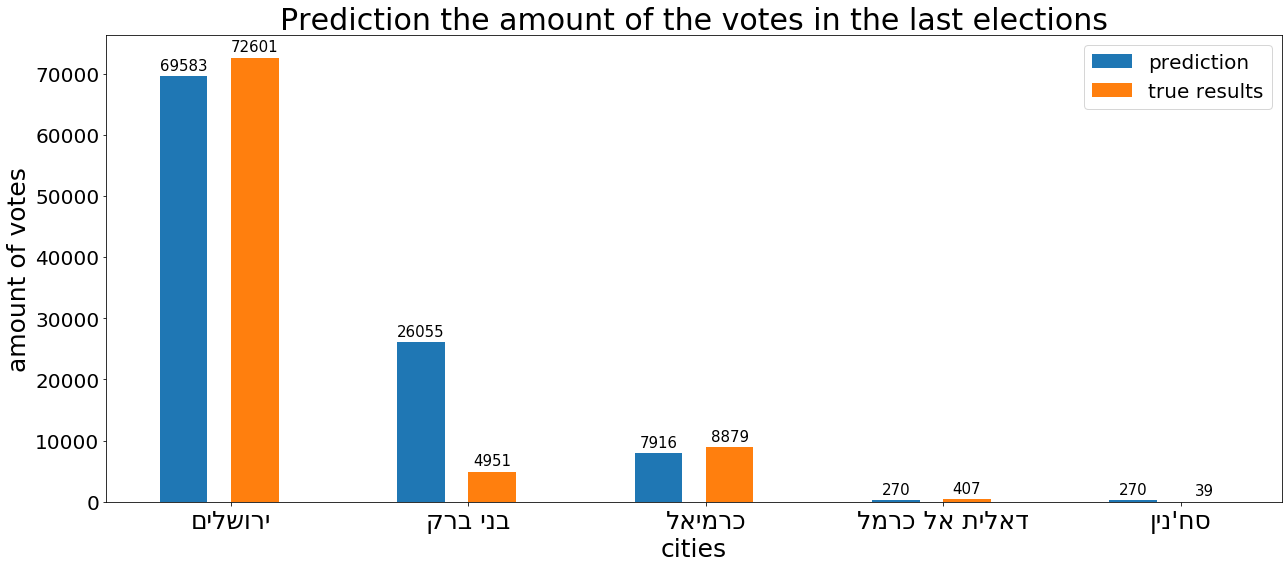

In [60]:
y_pred = [int(i) for i in y_pred] 
plt_per_party(y_result_likud,y_pred)

In [61]:
likud_table = table_per_party(y_result_likud,y_pred)

In [62]:
likud_table

,cities names,predict,true results
0,ירושלים,69583,72601
1,בני ברק,26055,4951
2,כרמיאל,7916,8879
3,דאלית אל כרמל,270,407
4,סחנין,270,39


## kachol lavan

In [63]:
y_pred = ada_function(y_train_bw, y_test_bw, y_result_bw)

Best Parameters:
 {'learning_rate': 0.001, 'n_estimators': 50, 'random_state': 1}
mae: 509.66289886233267


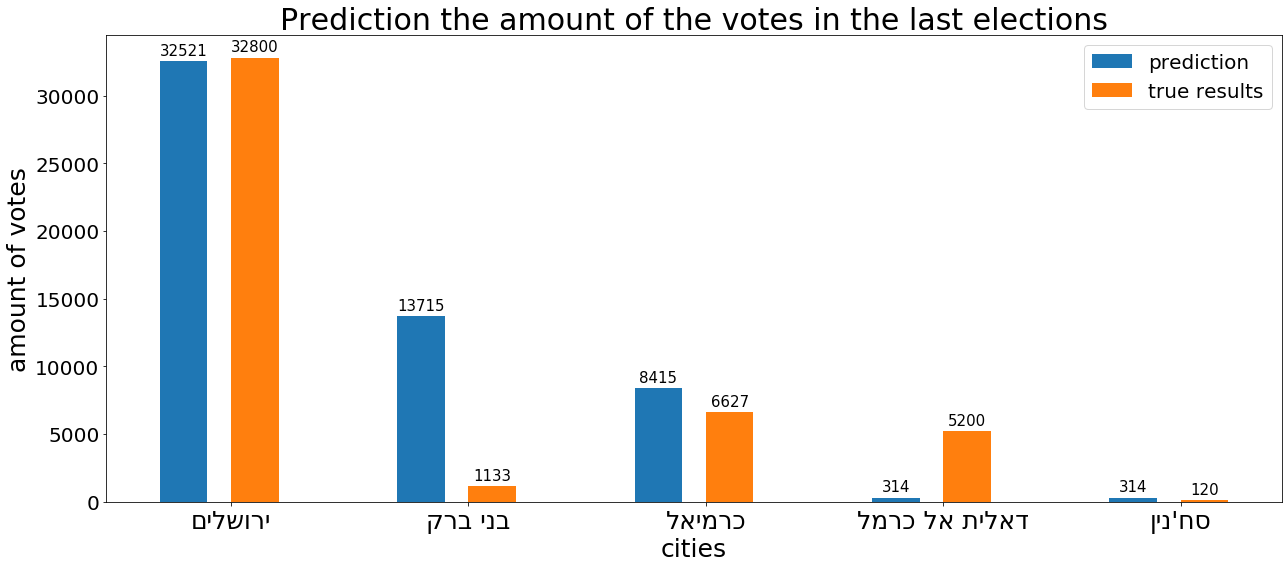

In [64]:
y_pred = [int(i) for i in y_pred] 
plt_per_party(y_result_bw,y_pred)

In [65]:
bw_table = table_per_party(y_result_bw,y_pred)

In [66]:
bw_table

,cities names,predict,true results
0,ירושלים,32521,32800
1,בני ברק,13715,1133
2,כרמיאל,8415,6627
3,דאלית אל כרמל,314,5200
4,סחנין,314,120


## Reshima meshuteft

In [67]:
y_pred = ada_function(y_train_meshutefet, y_test_meshutefet, y_result_meshutefet)

Best Parameters:
 {'learning_rate': 0.01, 'n_estimators': 250, 'random_state': 1}
mae: 177.6272977732724


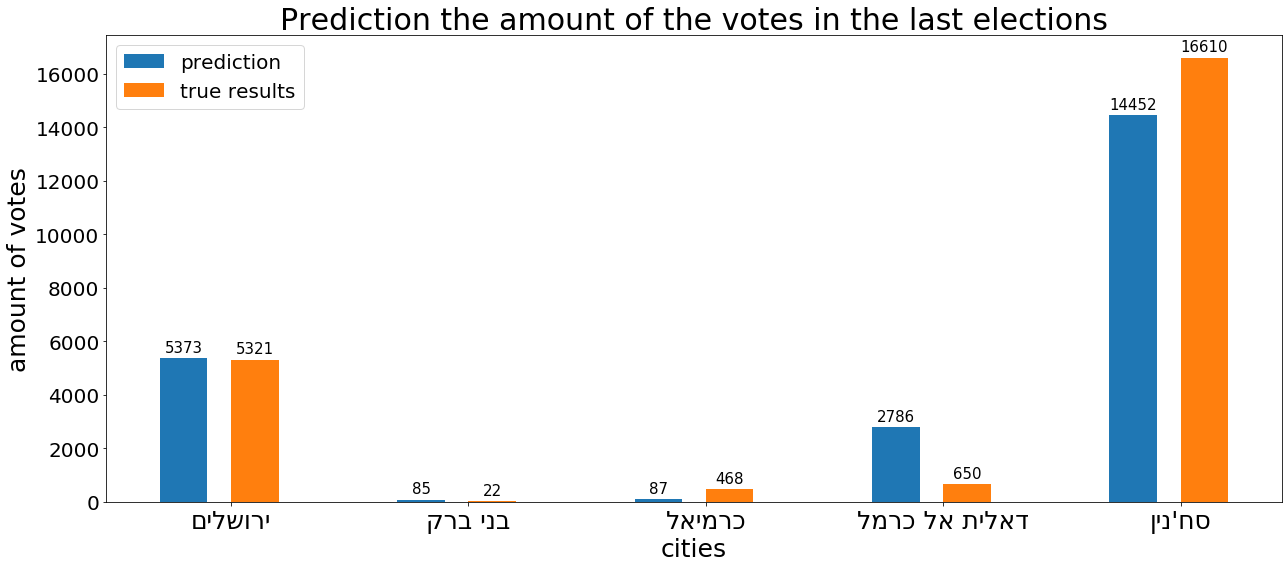

In [68]:
y_pred = [int(i) for i in y_pred] 
plt_per_party(y_result_meshutefet,y_pred)

In [69]:
meshuteftet_table = table_per_party(y_result_meshutefet,y_pred)

In [70]:
meshuteftet_table

,cities names,predict,true results
0,ירושלים,5373,5321
1,בני ברק,85,22
2,כרמיאל,87,468
3,דאלית אל כרמל,2786,650
4,סחנין,14452,16610


# 6- invalid votes

## We decided that representatives should be placed in every settlement where (valid_votes^2/all_voters^2)<0.97

# We used Decision Tree Classifier for this assignment because we want to use supervised learning
## 1 denotes that theres needs to be a representative

In [71]:
kal21 = pd.read_excel("21_elec/21_election_stats.xlsx" , sheet_name ="kalpi1")
kal22 = pd.read_excel("21_elec/21_election_stats.xlsx" , sheet_name ="kalpi2")
kal23 = pd.read_excel("21_elec/21_election_stats.xlsx" , sheet_name ="kalpi3")

In [72]:
dict_names = {'מחל': 'likud', 'פה':'kahol-lavan', 'אמת': 'avoda-etc', 'שס': 'shas', 'ג': 'yahadut-hatora', 'ל': 'israel-beitenu', 'טב': 'yamina', 'ודעם': 'meshutefet'}

def merge_parties_and_remove_losers(df):
    df.drop(columns = 'שם ישוב', inplace = True)
    mergable = {'נ': 'טב', 'כ': 'מחל', 'מרצ': 'אמת', 'נר': 'אמת','ום': 'ודעם', 'ז': 'מחל'}
    df.rename(columns = {'דעם': 'ודעם'}, inplace=True)
    
    for key,value in mergable.items():
        if (key in df.columns):
                df[value] += df[key]
                df.drop(columns = key, inplace=True)
                
    thresh = df.sum(axis=0, numeric_only = True) 
    df = df[df.columns[thresh>100000]]
    df.rename(columns = dict_names, inplace = True)
    return df

In [73]:
kal21 = merge_parties_and_remove_losers(kal21.copy())
kal22 = merge_parties_and_remove_losers(kal22.copy())
kal23 = merge_parties_and_remove_losers(kal23.copy())

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [74]:
filt21 = ((kal21['כשרים']**2)/kal21['מצביעים']**2)<0.97
filt22 = ((kal22['כשרים']**2)/kal22['מצביעים']**2)<0.97
filt23 = ((kal23['כשרים']**2)/kal23['מצביעים']**2)<0.97

In [75]:
kal21['invalid'] = kal21['מצביעים'] - kal21['כשרים']
kal22['invalid'] = kal22['מצביעים'] - kal22['כשרים']
kal23['invalid'] = kal23['מצביעים'] - kal23['כשרים']

In [76]:
kal21['judge'] = 0
kal21.loc[filt21, ['judge']] = 1 
kal22['judge'] = 0
kal22.loc[filt22, 'judge'] = 1
kal23['judge'] = 0
kal23.loc[filt23, 'judge'] = 1

In [77]:
X_train = kal21.iloc[:,:-1].append(kal22.iloc[:,:-1], ignore_index = True)
X_test = kal23.iloc[:,:-1]
y_train = kal21['judge'].append(kal22['judge'], ignore_index = True)
y_test = kal23['judge']

In [78]:
X_test = X_test.set_index('סמל ישוב').join(israel).drop(columns = ['קואורדינטות','אזור טבעי','צורת יישוב שוטפת','סך הכל אוכלוסייה 2018', 'תעתיק','מחוז','יהודים ואחרים' ,'השתייכות ארגונית', 'גובה', 'שם יישוב באנגלית', 'אשכול רשויות מקומיות', 'שנה', 'ועדת תכנון','שם יישוב','סמל יישוב','מרחב משטרה', 'שנת ייסוד', 'ערבים', 'מזה: יהודים', 'מעמד מונציפאלי', 'שיוך מטרופוליני'])

X_test['דת יישוב'].fillna((2), inplace=True)
X_test['נפה'].fillna((X_test['נפה'].median()), inplace=True)

In [79]:
X_train = X_train.set_index('סמל ישוב').join(israel).drop(columns = ['קואורדינטות','אזור טבעי','צורת יישוב שוטפת','סך הכל אוכלוסייה 2018', 'תעתיק','מחוז','יהודים ואחרים' ,'השתייכות ארגונית', 'גובה', 'שם יישוב באנגלית', 'אשכול רשויות מקומיות', 'שנה', 'ועדת תכנון','שם יישוב','סמל יישוב','מרחב משטרה', 'שנת ייסוד', 'ערבים', 'מזה: יהודים', 'מעמד מונציפאלי', 'שיוך מטרופוליני'])

X_train['דת יישוב'].fillna((2), inplace=True)
X_train['נפה'].fillna((X_train['נפה'].median()), inplace=True)

In [80]:
X_train = X_train.drop(columns = ['בזב', 'מצביעים', 'מספר קלפי','קלפי', 'ברזל','סמל ועדה', 'ריכוז'])
X_test = X_test.drop(columns = ['בזב', 'מצביעים', 'קלפי', 'ברזל', 'ריכוז', 'סמל ועדה'])

In [81]:
X_test.head()

,כשרים,avoda-etc,yahadut-hatora,meshutefet,yamina,israel-beitenu,likud,kahol-lavan,shas,invalid,נפה,דת יישוב
7,387,21,6,0,16,11,175,108,48,0,62.0,2.0
10,252,2,3,0,10,1,136,5,94,0,62.0,3.0
11,271,29,0,1,15,18,85,114,7,0,62.0,2.0
13,391,45,1,0,26,12,30,274,1,5,24.0,1.0
15,234,1,2,0,5,0,175,7,42,1,21.0,1.0


In [82]:
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

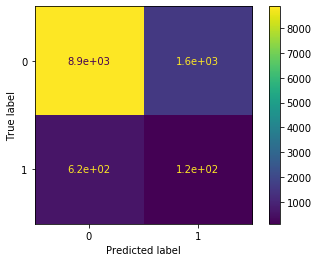

In [83]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(clf, X_test, y_test) 
plt.show()  

In [84]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8045442347258253


In [85]:
# Create a dictionary of all the parameter options 
param_grid ={
             'max_depth':[2,3,4,5,6,7,8,9,10],
             'min_samples_split':[2,3,4,5,6,7,8]
            }
    
# Create a grid search object
gsDCT = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')

# Fit the grid search
gsDCT.fit(X_train, y_train)

print(gsDCT.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [86]:
y_pred = gsDCT.predict(X_test)

In [87]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8921191519813937


[[9933  506]
 [ 700   40]]


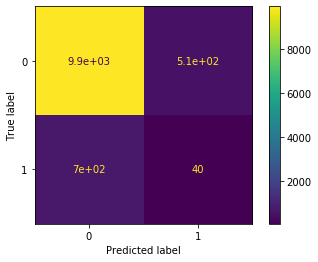

In [88]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plot_confusion_matrix(gsDCT.best_estimator_, X_test, y_test)
plt.show() 

# Cities where Decision Tree decided to place representatives

In [89]:
X_test.loc[y_pred == 1]

,כשרים,avoda-etc,yahadut-hatora,meshutefet,yamina,israel-beitenu,likud,kahol-lavan,shas,invalid,נפה,דת יישוב
7,387,21,6,0,16,11,175,108,48,0,62.0,2.0
10,252,2,3,0,10,1,136,5,94,0,62.0,3.0
11,271,29,0,1,15,18,85,114,7,0,62.0,2.0
27,202,5,1,0,13,4,111,14,53,0,75.0,1.0
28,409,34,2,0,13,45,138,168,7,2,62.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1374,213,0,1,0,180,1,26,0,1,0,62.0,1.0
1376,359,2,7,0,82,0,193,15,50,1,62.0,1.0
1376,398,6,8,0,91,3,218,28,38,1,62.0,1.0
1412,140,9,0,0,8,4,44,73,2,1,77.0,1.0


# הסוף :)